In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import pandas as pd
import random

import numpy as np
import scipy.stats as scs

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from collections import Counter, deque
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df = yf.download('^GSPC', start="2000-01-01", end="2024-04-30", interval="1d")
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


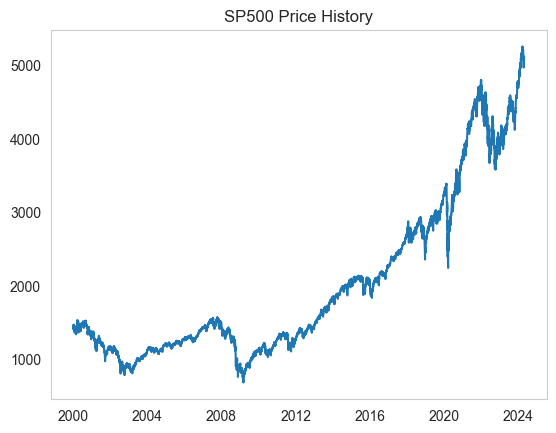

In [3]:
plt.title(f'SP500 Price History')
plt.plot(
    list(i for i in df.index),
    list(i[4] for i in df.values))
plt.grid(False)

<Axes: title={'center': 'Excess returns'}, xlabel='Date'>

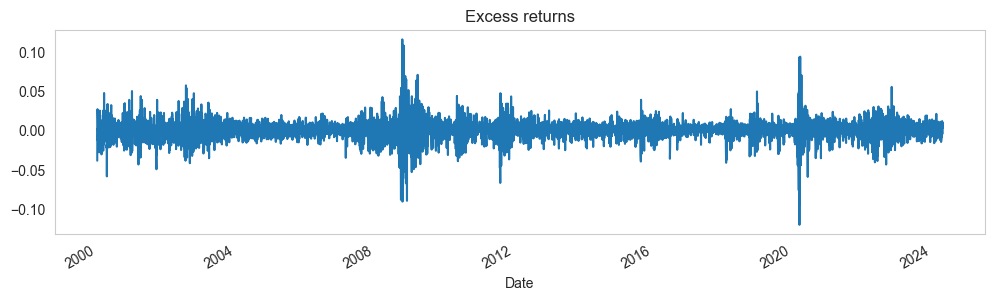

In [4]:
df['r-1'] = df['Adj Close'].pct_change().dropna()

ex_ret = df['r-1']
ex_ret.plot(title='Excess returns', figsize=(12, 3), grid=False)

In [18]:
# Fit the model
mod_kns = sm.tsa.MarkovRegression(ex_ret.dropna(), k_regimes=2, trend='n', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                    r-1   No. Observations:                 6118
Model:               MarkovRegression   Log Likelihood               19457.309
Date:                Tue, 30 Apr 2024   AIC                         -38906.618
Time:                        17:37:08   BIC                         -38879.742
Sample:                             0   HQIC                        -38897.294
                               - 6118                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.077e-05   1.64e-06     30.898      0.000    4.75e-05     5.4e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   1.57e-05     24.182      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9900      0.002    497.402      0.000       0.986       0.994
p[1->0]        0.0224      0.005      4.944      0.000       0.013       0.031
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [19]:
res_kns.smoothed_marginal_probabilities.head()

,0,1
Date,,
2000-01-04,0.000003,0.999997
2000-01-05,0.002775,0.997225
2000-01-06,0.002962,0.997038
2000-01-07,0.000703,0.999297
2000-01-10,0.012441,0.987559


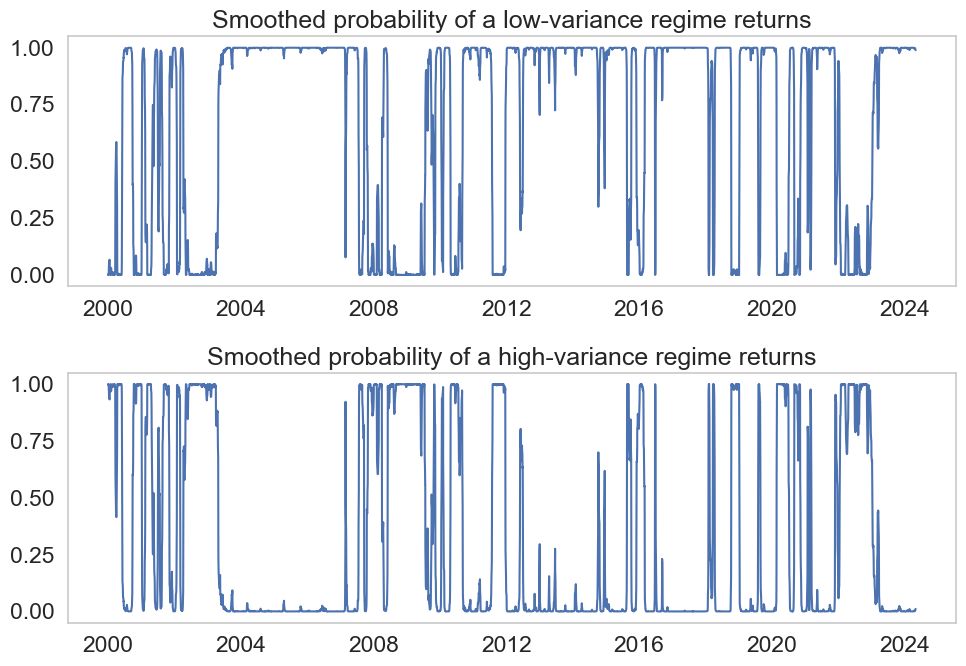

In [21]:
fig, axes = plt.subplots(2, figsize=(10,7))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.grid(False)
ax.set(title='Smoothed probability of a low-variance regime returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a high-variance regime returns')
fig.tight_layout()
ax.grid(False)

In [22]:
low_var = list(res_kns.smoothed_marginal_probabilities[0])
high_var = list(res_kns.smoothed_marginal_probabilities[1])

regime_list = []
for i in range(0, len(low_var)):
    if low_var[i] > high_var[i]:
        regime_list.append(0)
    else:
        regime_list.append(1)

In [24]:
regime_df = pd.DataFrame()
regime_df['regimes'] = regime_list

In [25]:
sns.set(font_scale=1.5)
df = df.iloc[len(df)-len(regime_list):]
regimes = (pd.DataFrame(regime_list, columns=['regimes'], index=df.index)
          .join(df, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
regimes.head()

,Date,regimes,Open,High,Low,Close,Adj Close,Volume,r-1
0,2000-01-04,1,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,-0.038345
1,2000-01-05,1,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,0.001922
2,2000-01-06,1,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,0.000956
3,2000-01-07,1,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,0.027090
4,2000-01-10,1,1441.469971,1464.359985,1441.469971,1457.599976,1457.599976,1064800000,0.011190


Text(0.5, 0.98, 'Historical SP500 regimes')

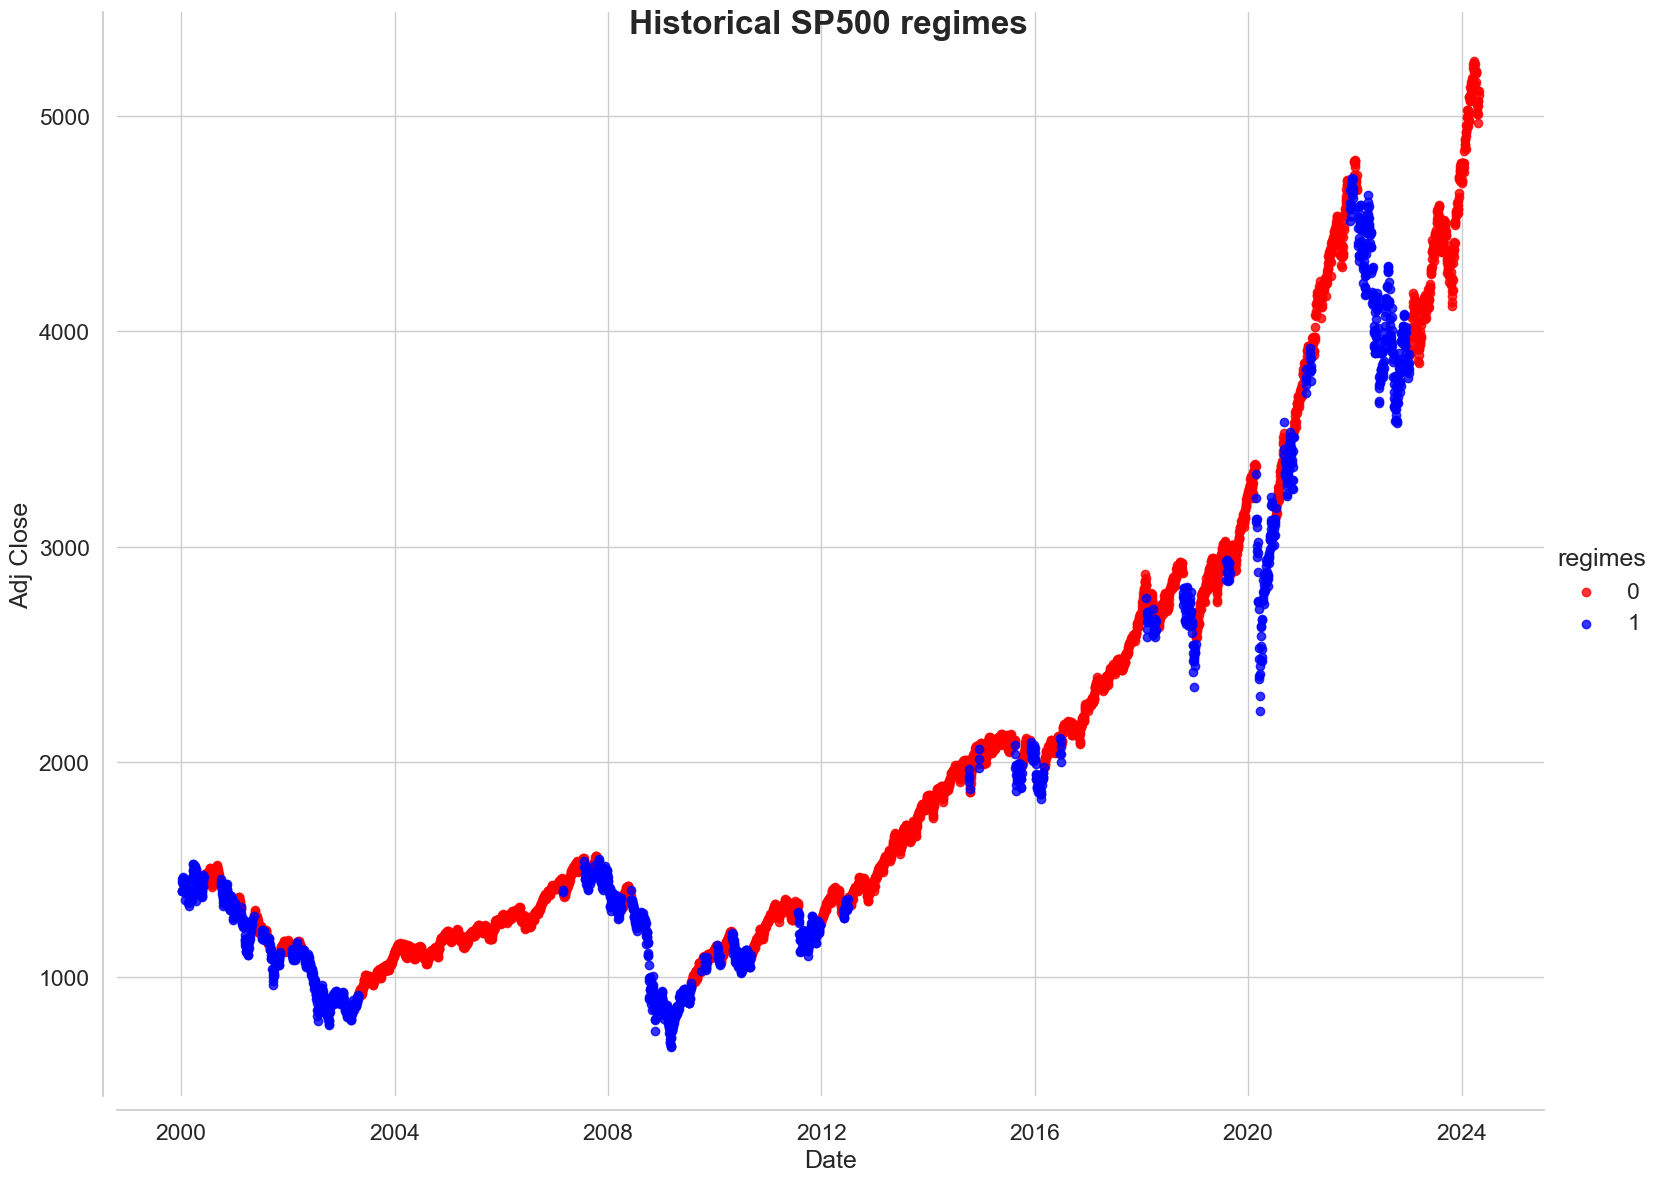

In [27]:
import warnings
warnings.filterwarnings("ignore")
colors = 'red', 'blue'
sns.set_style("whitegrid")
order = [0, 1]
fg = sns.FacetGrid(data=regimes, hue='regimes', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'Date', "Adj Close", alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical SP500 regimes', fontsize=24, fontweight='demi')